# <center> Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

###### Примечание. 
###### Ориентировочное время отработки ноутбука составляет 30 минут

### Импорт библиотек

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn import model_selection #методы разделения и валидации
from sklearn.model_selection import cross_val_score

# методы подбора гиперпараметров
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna


%matplotlib inline
plt.style.use('seaborn')
random_state = 42

import warnings

warnings.filterwarnings('ignore')

### Прочитаем данные и посмотрим на них

In [2]:
df = pd.read_csv('_train_sem09 (1).csv')
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


1    2034
0    1717
Name: Activity, dtype: int64


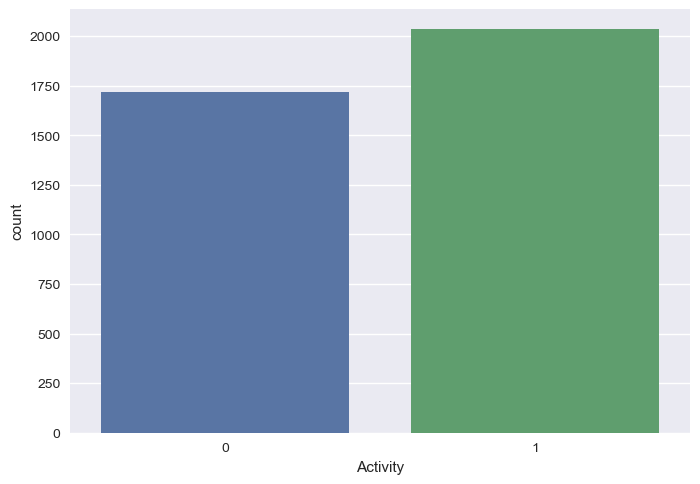

In [4]:
print(df.Activity.value_counts())
sns.countplot(data=df, x='Activity');

Классы целевой переменной сбалансированы, поэтому при разбиении stratify можем не использовать (при попытке использовать значение f1_score уменьшается)

### <center> Т.к. данные подготовлены (из условий задачи), можно сразу построить первую модель на всех признаках без подбора параметров, чтобы получить базовое значение метрики f1_score

In [5]:
# Выделим из датафрейма матрицу наблюдений X и вектор целевого признака y
X = df.drop('Activity', axis = 1)
y = df['Activity']

# Разобъем данные на тренировочную, валидационную и тестовые выборки.
# Обучаем не тренировочной, подбираем параметры на валидационной, тестируем на тестовой.

X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y,
                                                      #stratify = y,
                                                      test_size = 0.2,
                                                      random_state = random_state
                                                     )
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, 
                                                    y_valid,
                                                    #stratify = y_valid,
                                                    test_size = 0.5, 
                                                    random_state = random_state
                                                   )

In [6]:
# Нормализуем данные

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Обучим базовую модель Линейной Регрессии и получим предсказания и f1_score для валидационной и тестовой выборок

lr = linear_model.LogisticRegression(random_state = random_state)
lr.fit(X_train_scaled, y_train)

y_pred_tr_lr = lr.predict(X_train_scaled)
y_pred_val_lr = lr.predict(X_valid_scaled)
y_pred_test_lr = lr.predict(X_test_scaled)

f1_score_tr = round(metrics.f1_score(y_train, y_pred_tr_lr),3)
f1_score_val = round(metrics.f1_score(y_valid, y_pred_val_lr),3)
f1_score_test = round(metrics.f1_score(y_test, y_pred_test_lr),3)

print('Модель Logistic Regression')
print(f'Базовое значение f1_score для нормализованной тренировочной выборки составляет: {f1_score_tr}')
print(f'Базовое значение f1_score для нормализованной валидационной выборки составляет: {f1_score_val}')
print(f'Базовое значение f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Logistic Regression
Базовое значение f1_score для нормализованной тренировочной выборки составляет: 0.889
Базовое значение f1_score для нормализованной валидационной выборки составляет: 0.775
Базовое значение f1_score для нормализованной тестовой выборки составляет: 0.802


In [8]:
# Обучим базовую модель Случайный Лес и получим предсказания и f1_score для валидационной и тестовой выборок

rfc = ensemble.RandomForestClassifier(random_state = random_state)
rfc.fit(X_train_scaled, y_train)

y_pred_tr_rfc = rfc.predict(X_train_scaled)
y_pred_val_rfc = rfc.predict(X_valid_scaled)
y_pred_test_rfc = rfc.predict(X_test_scaled)

f1_score_tr = round(metrics.f1_score(y_train, y_pred_tr_rfc),3)
f1_score_val = round(metrics.f1_score(y_valid, y_pred_val_rfc),3)
f1_score_test = round(metrics.f1_score(y_test, y_pred_test_rfc),3)

print('Модель Random Forest')
print(f'Базовое значение f1_score для нормализованной тренировочной выборки составляет: {f1_score_tr}')
print(f'Базовое значение f1_score для нормализованной валидационной выборки составляет: {f1_score_val}')
print(f'Базовое значение f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Random Forest
Базовое значение f1_score для нормализованной тренировочной выборки составляет: 1.0
Базовое значение f1_score для нормализованной валидационной выборки составляет: 0.828
Базовое значение f1_score для нормализованной тестовой выборки составляет: 0.828


Значение f1_score, которое мы получили с помощью базового алгоритма Random Forest лучше, чем у базового алгоритма Logistic Regression

Посчитаем значение f1_score на кросс-валидации StratifiedKFold для 5 fold

In [9]:
#Создаём объект кросс-валидатора StratifiedKFold
skf = model_selection.StratifiedKFold(n_splits = 5)

#Считаем метрики на кросс-валидации StratifiedKFold
cv_metrics = model_selection.cross_validate(estimator = rfc, #модель 
                                            X = X_train_scaled, #матрица наблюдений X
                                            y = y_train, #вектор ответов y
                                            cv = skf, #кросс-валидатор
                                            scoring = 'f1', #метрика
                                            return_train_score = True #подсчёт метрики на тренировочных фолдах
                                           )
display(pd.DataFrame(cv_metrics))
print('Тренировочное значение f1_score на кросс-валидации составило: ', round(cv_metrics['train_score'].mean(),3))
print('Тестовое значение f1_score на кросс-валидации составило: ', round(cv_metrics['test_score'].mean(),3))

,fit_time,score_time,test_score,train_score
0,0.805426,0.015702,0.794953,1.0
1,0.802379,0.015627,0.798151,1.0
2,0.814219,0.015611,0.807512,1.0
3,0.785961,0.015618,0.812698,1.0
4,0.806181,0.015611,0.819723,1.0


Тренировочное значение f1_score на кросс-валидации составило:  1.0
Тестовое значение f1_score на кросс-валидации составило:  0.807


На кросс-валидации значение метрики f1_score хуже, чем на Random Forest

## <center> Проведем 2 вида оптимизации: базовую и прдвинутую для 2-х вариантов моделей: Логистическая Регрессия и Случайный Лес

### <center> Базовая оптимизация включает в себя алгоритмы: GridSearchCV и RandomizedSearchCV

 ### <center> 1. GridSearchCV

Подберем гиперпараметры для Логистической Регрессии

In [10]:
param_grid = {'penalty': ['l2', 'none'], # тип регурялизации
              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] # алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, # генератор случайных чисел
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  

%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на валидационном наборе: {:.2f}".format(grid_search.score(X_valid_scaled, y_valid)))
y_valid_pred = grid_search.predict(X_valid_scaled)
print('f1_score на валидационном наборе: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Wall time: 1min 10s
accuracy на валидационном наборе: 0.74
f1_score на валидационном наборе: 0.77
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'newton-cg'}


В результате значение f1_score для валидационной выборки не увеличился по сравнению с базовым значением

Попробуем расширить сетку гиперпараметров

In [11]:
param_grid = {'penalty': ['l2', 'none'], # тип регурялизации
              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], # алгоритм оптимизации
              'max_iter': [100, 1500, 500] # количество итераций на сходимость
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, # генератор случайных чисел
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  

%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на валидационном наборе: {:.2f}".format(grid_search.score(X_valid_scaled, y_valid)))
y_test_pred = grid_search.predict(X_valid_scaled)
print('f1_score на валидационном наборе: {:.2f}'.format(metrics.f1_score(y_valid, y_pred_val_lr)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Wall time: 4min 48s
accuracy на валидационном наборе: 0.74
f1_score на валидационном наборе: 0.77
Наилучшие значения гиперпараметров: {'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


Снова изменений нет, хотя времени понадобилось в 4 раза больше.

Попробуем еще один раз - добавим коэффициент регуляризации, но уменьшим количество алгоритмов сходимости и вариации max_iter, потому что нужно будет очень много времени для расчетов.

In [12]:
param_grid = {'penalty': ['l2', 'none'], # тип регурялизации
              'solver': ['lbfgs', 'newton-cg'], # алгоритм оптимизации
              'max_iter': [100, 1000], # количество итераций на сходимость
              'C': [0.01, 1] # уровень силы регурялизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, # генератор случайных чисел
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  

%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на валидационном наборе: {:.2f}".format(grid_search.score(X_valid_scaled, y_valid)))
y_test_pred = grid_search.predict(X_valid_scaled)
print('f1_score на валидационном наборе: {:.2f}'.format(metrics.f1_score(y_valid, y_pred_val_lr)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Wall time: 5min 5s
accuracy на валидационном наборе: 0.74
f1_score на валидационном наборе: 0.77
Наилучшие значения гиперпараметров: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


Результат тот же

Посчитаем значение f1_score на тестовой выборке с подобранными гиперпараметрами:

In [13]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(C=1, random_state=42, solver='newton-cg')


In [14]:
lr = linear_model.LogisticRegression(C = 1, random_state = random_state, solver = 'newton-cg')
lr.fit(X_train_scaled, y_train)

y_pred_test_lr = lr.predict(X_test_scaled)

f1_score_test = round(metrics.f1_score(y_test, y_pred_test_lr),3)

print('Модель Logistic Regression с подобранными гиперпараметрами GridSearchCV')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Logistic Regression с подобранными гиперпараметрами GridSearchCV
f1_score для нормализованной тестовой выборки составляет: 0.806


Результат для тестовой выборки улучшен.

Для базовой модели: f1_score = 0.802

Для GridSearchCV модели: f1_score = 0.806

Подберем гиперпараметры для Случайного Леса

In [15]:
param_grid = {'n_estimators': list(range(80, 100, 150)),
              'min_samples_leaf': [5, 7],
              'max_depth': list(np.linspace(20, 40, 5, dtype = int))
              }
            
grid_search_forest = GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state = random_state), 
    param_grid = param_grid, 
    cv = 5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на валидационном наборе: {:.2f}".format(grid_search_forest.score(X_valid_scaled, y_valid)))
y_valid_pred = grid_search_forest.predict(X_valid_scaled)
print('f1_score на валидационном наборе: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

Wall time: 9.68 s
f1_score на обучающем наборе: 0.94
accuracy на валидационном наборе: 0.82
f1_score на валидационном наборе: 0.84
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 80}


Смогли улучшить значение f1_score (и accuracy тоже), попробуем еще расширить сетку параметров

In [16]:
param_grid = {'n_estimators': list(range(80, 100, 150)),
              'min_samples_leaf': [5, 7],
              'max_depth': list(np.linspace(20, 40, 5, dtype = int)),
              'criterion': ['gini', 'entropy']
              }
            
grid_search_forest = GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state = random_state), 
    param_grid = param_grid, 
    cv = 5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на валидационном наборе: {:.2f}".format(grid_search_forest.score(X_valid_scaled, y_valid)))
y_valid_pred = grid_search_forest.predict(X_valid_scaled)
print('f1_score на валидационном наборе: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

Wall time: 17.9 s
f1_score на обучающем наборе: 0.95
accuracy на валидационном наборе: 0.80
f1_score на валидационном наборе: 0.82
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 5, 'n_estimators': 80}


Значение целевой метрики ухудшилось, откатимся к предыдущему варианту и посчитаем f1_score на тестовой выборке

In [17]:
rfc = ensemble.RandomForestClassifier(max_depth = 30, 
                                      min_samples_leaf = 5, 
                                      n_estimators = 80, 
                                      random_state = random_state)
rfc.fit(X_train_scaled, y_train)

y_pred_val_rfc = rfc.predict(X_valid_scaled)
y_pred_test_rfc = rfc.predict(X_test_scaled)

f1_score_val = round(metrics.f1_score(y_valid, y_pred_val_rfc),3)
f1_score_test = round(metrics.f1_score(y_test, y_pred_test_rfc),3)

print('Модель Random Forest с подобранными гиперпараметрами GridSearchCV')
print(f'f1_score для нормализованной валидационной выборки составляет: {f1_score_val}')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Random Forest с подобранными гиперпараметрами GridSearchCV
f1_score для нормализованной валидационной выборки составляет: 0.837
f1_score для нормализованной тестовой выборки составляет: 0.831


Результат для тестовой выборки улучшен.

Для базовой модели: f1_score = 0.828

Для GridSearchCV модели: f1_score = 0.831

Не знаю, почему, но параметр max_depth = 30 дает лучший результат, чем max_depth = 20.. 

Хотя предыдущий вариант лучших параметров говорит нам о том, что нужно использовать max_depth = 20

Попробуем провести кросс-валидацию на 5 fold

In [18]:
#Создаём объект кросс-валидатора StratifiedKFold
skf = model_selection.StratifiedKFold(n_splits = 5)

#Считаем метрики на кросс-валидации StratifiedKFold
cv_metrics = model_selection.cross_validate(estimator = rfc, #модель 
                                            X = X_train_scaled, #матрица наблюдений X
                                            y = y_train, #вектор ответов y
                                            cv = skf, #кросс-валидатор
                                            scoring = 'f1', #метрика
                                            return_train_score = True #подсчёт метрики на тренировочных фолдах
                                           )
display(pd.DataFrame(cv_metrics))
print('Тренировочное значение f1_score на кросс-валидации составило: ', round(cv_metrics['train_score'].mean(),3))
print('Тестовое значение f1_score на кросс-валидации составило: ', round(cv_metrics['test_score'].mean(),3))

,fit_time,score_time,test_score,train_score
0,0.734763,0.015618,0.786624,0.943323
1,0.750949,0.015599,0.806107,0.943951
2,0.579041,0.015625,0.790123,0.940948
3,0.641086,0.015630,0.802488,0.945935
4,0.703129,0.015615,0.819970,0.939218


Тренировочное значение f1_score на кросс-валидации составило:  0.943
Тестовое значение f1_score на кросс-валидации составило:  0.801


Кросс-валидация дает хуже результат, чем обычная тест выборка

#### Выводы по GridSearchCV

1. GridSearchCV для Логистической регрессии немного увеличил значение целевой метрики осталось неизменным. Долго происходит подбор параметров.

2. GridSearchCV для Случайного Леса принес результат - подобрав параметры мы смогли увеличить значение целевой метрики. Параметры считаются (подбираются) быстрее.

 ### <center> 2. RandomizedSearchCV

Подберем параметры для Логистичекой регрессии, обучим модель с этими параметрами и сравним результат с базовым значением

In [19]:
param_distributions = {'penalty': ['l2', 'none'],
                       'solver': ['lbfgs', 'newton-cg'],
                       'C': list(np.linspace(0.01, 1, 10, dtype=float)),
                       'max_iter': [100, 1000]
                       },
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train_scaled, y_train) 
print("accuracy на валидационном наборе: {:.2f}".format(random_search.score(X_valid_scaled, y_valid)))
y_valid_pred = random_search.predict(X_valid_scaled)
print('f1_score на валидационном наборе: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

Wall time: 5min 55s
accuracy на валидационном наборе: 0.74
f1_score на валидационном наборе: 0.77
Наилучшие значения гиперпараметров: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 100, 'C': 0.34}


Удалось увеличить значение f1_score на валидационной выборке

Попробуем построить на этих параметрах модель и получить значение целевой метрики на тестовой выборке

In [20]:
lr = linear_model.LogisticRegression(C = 0.12, 
                                     max_iter = 1000, 
                                     penalty = 'l2', 
                                     solver='newton-cg', 
                                     random_state = random_state)
lr.fit(X_train_scaled, y_train)

y_pred_test_lr = lr.predict(X_test_scaled)

f1_score_test = round(metrics.f1_score(y_test, y_pred_test_lr),3)

print('Модель Logistic Regression с подобранными гиперпараметрами GridSearchCV')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Logistic Regression с подобранными гиперпараметрами GridSearchCV
f1_score для нормализованной тестовой выборки составляет: 0.799


Результат для тестовой выборки не улучшен.

Для базовой модели: f1_score = 0.802

Для GridSearchCV модели: f1_score = 0.806

Для RandomizedSearchCV модели: f1_score = 0.799

Подберем параметры для случайного леса

In [21]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
                       'min_samples_leaf': [5, 7, 12],
                       'max_depth': list(np.linspace(20, 40, 10, dtype = int)),
                       'criterion': ['gini', 'entropy', 'log_loss']
                      }
            
random_search_forest = RandomizedSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state = random_state), 
    param_distributions = param_distributions, 
    cv = 5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на валидационном наборе: {:.2f}".format(random_search_forest.score(X_valid_scaled, y_valid)))
y_valid_pred = random_search_forest.predict(X_valid_scaled)
print('f1_score на валидационном наборе: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

Wall time: 11 s
f1_score на обучающем наборе: 0.94
accuracy на валидационном наборе: 0.82
f1_score на валидационном наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 140, 'min_samples_leaf': 5, 'max_depth': 35, 'criterion': 'gini'}


Значение целевой метрики на валидационных данных улучшилось, попробуем подставить параметры в модель и проверить значение f1_score на тестовой выборке

In [22]:
rfc = ensemble.RandomForestClassifier(criterion = 'entropy',
                                      max_depth = 31, 
                                      min_samples_leaf = 5, 
                                      n_estimators = 170,
                                      random_state = random_state)
rfc.fit(X_train_scaled, y_train)

y_pred_val_rfc = rfc.predict(X_valid_scaled)
y_pred_test_rfc = rfc.predict(X_test_scaled)

f1_score_val = round(metrics.f1_score(y_valid, y_pred_val_rfc),3)
f1_score_test = round(metrics.f1_score(y_test, y_pred_test_rfc),3)

print('Модель Random Forest с подобранными гиперпараметрами RandomizedSearchCV')
print(f'f1_score для нормализованной валидационной выборки составляет: {f1_score_val}')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Random Forest с подобранными гиперпараметрами RandomizedSearchCV
f1_score для нормализованной валидационной выборки составляет: 0.83
f1_score для нормализованной тестовой выборки составляет: 0.833


Результат для тестовой выборки улучшен.

Для базовой модели: f1_score = 0.828

Для GridSearchCV модели: f1_score = 0.831

Для RandomizedSearchCV модели: f1_score = 0.833

#### Выводы по RandomizedSearchCV

1. RandomizedSearchCV для Логистической регрессии не принес ничего, значение целевой метрики даже немного ухудшилось. 

2. GridSearchCV для Случайного Леса принес результат - подобрав параметры мы смогли еще немного увеличить значение целевой метрики. 

#### Общий вывод по простым алгоритмам подбора параметров
Сами алгоритмы работают, подбирают необходимые параметры и иногда, можно добиться ощутимого увеличения целевой метрики.

При этом нужно запастись терпением и временем для перебора различных вариантов гиперпараметров.

В целом, RandomizedSearchCV лучше справляется, чем GridSearchCV - быстрее и качественнее. Можно скормить ему больше вариантов параметров, это не увеличивает время на подбор, но больше вероятность попасть в нужный набор.

### <center> Продвинутая оптимизация включает в себя алгоритмы: Tree-Structured Parzen Estimators (TPE) библиотеки Hyperopt  и библиотеку OPTUNA

 ### <center> 1. Hyperopt

Сначала подберем параметры для модели Логистической Регрессии

In [23]:
# зададим пространство поиска гиперпараметров
space_lr = {'penalty': hp.choice('penalty', ['l2', 'none']), 
            'solver': hp.choice('solver', ['newton-cg', 'lbfgs', 'sag', 'saga']),
            #'C': hp.loguniform('C', low=-0.1*np.log(10), high=0.1*np.log(10)), # не улучшает результат, замедляет работу 
            'max_iter': hp.quniform('max_iter', 100, 1000, 1)
           }

In [24]:
# Необходимо создать функцию для минимизации 
# Она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции
# Подбирать параметры будем на валидационной выборке

def hyperopt_lr(params, cv = 5, X = X_valid_scaled, y = y_valid, random_state = random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': str(params['penalty']),
              'solver': str(params['solver']),
              #'C': float(params['C']),
              'max_iter': int(params['max_iter'])
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state = random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # метрику необходимо минимизировать, поэтому ставим знак минус
    print(params, score)
    return -score

# И та же функция, только обучение модели проводится с помощью кросс-валидации
# При этом, кросс-валидацию проведем на тренировочной выборке

def hyperopt_lr_cv(params, cv = 5, X = X_train_scaled, y = y_train, random_state = random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'],
              'solver': params['solver'],
              #'C': float(params['C']),
              'max_iter': int(params['max_iter'])
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state = random_state)

    # обучаем модель
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv = cv, scoring = "f1", n_jobs = -1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    print(params, score)
    return -score

In [25]:
# начинаем подбор гиперпараметров
trials_lr = Trials() # используется для логирования результатов

best = fmin(hyperopt_lr, # наша функция 
            space = space_lr, # пространство гиперпараметров
            algo = tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
            max_evals = 20, # максимальное количество итераций
            trials = trials_lr, # логирование результатов
            rstate = np.random.default_rng(random_state) # фиксируем для повторяемости результата
            #rstate = np.random.RandomState(random_state) # для версии Hyperopt ниже 0.2.7
           )
print(best)
print("Наилучшие значения гиперпараметров {}".format(best))

{'penalty': 'none', 'solver': 'newton-cg', 'max_iter': 658}                                                            
1.0                                                                                                                    
{'penalty': 'l2', 'solver': 'saga', 'max_iter': 647}                                                                   
0.9900497512437811                                                                                                     
{'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 166}                                                              
0.9900497512437811                                                                                                     
{'penalty': 'l2', 'solver': 'sag', 'max_iter': 291}                                                                    
0.9900497512437811                                                                                                     
{'penalty': 'none', 'solver': 'lbfgs', '

С помощью библиотеки Hyperopt были подобраны следующие параметры для Логистической регрессии:

- max_iter = 658
- penalty = 'none'
- solver = 'newton-cg'

Построим модель с этими параметрами и посчитаем f1_score

In [26]:
lr = linear_model.LogisticRegression(max_iter = 658, 
                                     penalty = 'none', 
                                     solver='newton-cg',
                                     random_state = random_state)
lr.fit(X_train_scaled, y_train)
y_pred_test_lr = lr.predict(X_test_scaled)

f1_score_test = round(metrics.f1_score(y_test, y_pred_test_lr),3)

print('Модель Logistic Regression с подобранными гиперпараметрами модулем Hyperopt')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Logistic Regression с подобранными гиперпараметрами модулем Hyperopt
f1_score для нормализованной тестовой выборки составляет: 0.706


На валидационной выборке значение f1_score = 1

Но на тестовой выборке, значение упало.

Возможно, наблюдается переобучение..
Попробуем подставить параметры, при которых значение f1_score на валидационной выборке не близко к 1.

In [27]:
lr = linear_model.LogisticRegression(max_iter = 533, 
                                     penalty = 'l2',
                                     solver='saga',
                                     random_state = random_state)
lr.fit(X_train_scaled, y_train)
y_pred_test_lr = lr.predict(X_test_scaled)

f1_score_test = round(metrics.f1_score(y_test, y_pred_test_lr),3)

print('Модель Logistic Regression с подобранными гиперпараметрами модулем Hyperopt')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Logistic Regression с подобранными гиперпараметрами модулем Hyperopt
f1_score для нормализованной тестовой выборки составляет: 0.807


Метрика улучшилась.. 

Попробуем посчитать метрику на кросс-валидации

In [28]:
# начинаем подбор гиперпараметров с кросс-валидацией 
trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_lr_cv, # наша функция 
            space = space_lr, # пространство гиперпараметров
            algo = tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
            max_evals = 20, # максимальное количество итераций
            trials = trials_lr, # логирование результатов
            rstate = np.random.default_rng(random_state) # фиксируем для повторяемости результата
            #rstate = np.random.RandomState(random_state) # для версии Hyperopt ниже 0.2.7
           )
print(best)
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?trial/s, best loss=?]
{'max_iter': 658.0, 'penalty': 1, 'solver': 0}
Наилучшие значения гиперпараметров {'max_iter': 658.0, 'penalty': 1, 'solver': 0}


На кросс-валидации показывает лучшие параметры:

- max_iter = 647
- penalty = 'l2'
- solver = 'saga'

тогда f1_score = 0.806.

Но, в одном из многочисленных опытов, выяснилось, что max_iter = 533 дает результат 0.807

Это не катастрофически лучше, но тем не менее..)

In [29]:
lr = linear_model.LogisticRegression(max_iter = 533, 
                                     penalty = 'l2',
                                     solver='saga',
                                     random_state = random_state)
lr.fit(X_train_scaled, y_train)
y_pred_test_lr = lr.predict(X_test_scaled)

f1_score_test = round(metrics.f1_score(y_test, y_pred_test_lr),3)

print('Модель Logistic Regression (СV) с подобранными гиперпараметрами модулем Hyperopt')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Logistic Regression (СV) с подобранными гиперпараметрами модулем Hyperopt
f1_score для нормализованной тестовой выборки составляет: 0.807


Промежуточный итог для Логистической регрессии

- Для базовой модели: f1_score = 0.802

- Для GridSearchCV модели: f1_score = 0.806

- Для RandomizedSearchCV модели: f1_score = 0.799

- Для Hyperopt модели: f1_score = 0.807

- Для Hyperopt модели на кросс-валидации: f1_score = 0.807

Подберем параметры для Случайного Леса

In [30]:
space_rf = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
            'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
            'max_depth': hp.quniform('max_depth', 15, 26, 1),
            'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
           }

In [31]:
# Необходимо создать такие же функции для минимизации, как и для логистической Регрессии 

def hyperopt_rf(params, X = X_valid_scaled, y = y_valid, random_state = random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'criterion': params['criterion'],
              'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf'])
             }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    print(params, score)
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

# И та же функция, только обучение модели проводится с помощью кросс-валидации
def hyperopt_rf_cv(params, cv = 5, X = X_train_scaled, y = y_train, random_state = random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'criterion': params['criterion'],
              'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv = cv, scoring = "f1", n_jobs = -1).mean()

    print(params, score)
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [32]:
trials_rf = Trials() # используется для логирования результатов

best = fmin(hyperopt_rf, # наша функция 
            space = space_rf, # пространство гиперпараметров
            algo = tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
            max_evals = 20, # максимальное количество итераций
            trials = trials_rf, # логирование результатов
            rstate = np.random.default_rng(random_state)# фиксируем для повторяемости результата
            #rstate = np.random.RandomState(random_state) # для версии Hyperopt ниже 0.2.7
           )
print("Наилучшие значения гиперпараметров {}".format(best))

{'criterion': 'entropy', 'n_estimators': 181, 'max_depth': 25, 'min_samples_leaf': 7}                                  
0.9408866995073892                                                                                                     
{'criterion': 'gini', 'n_estimators': 130, 'max_depth': 24, 'min_samples_leaf': 7}                                     
0.9261083743842363                                                                                                     
{'criterion': 'gini', 'n_estimators': 115, 'max_depth': 22, 'min_samples_leaf': 3}                                     
0.99                                                                                                                   
{'criterion': 'entropy', 'n_estimators': 140, 'max_depth': 22, 'min_samples_leaf': 4}                                  
0.9850746268656716                                                                                                     
{'criterion': 'entropy', 'n_estimators':

In [33]:
rfc = ensemble.RandomForestClassifier(criterion = 'entropy',
                                      max_depth = 18, 
                                      min_samples_leaf = 2, 
                                      n_estimators = 103,
                                      random_state = random_state)
rfc.fit(X_train_scaled, y_train)

y_pred_test_rfc = rfc.predict(X_test_scaled)

f1_score_test = round(metrics.f1_score(y_test, y_pred_test_rfc),3)

print('Модель Random Forest с подобранными гиперпараметрами Hyperopt')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Random Forest с подобранными гиперпараметрами Hyperopt
f1_score для нормализованной тестовой выборки составляет: 0.831


Значение метрики ухудшилось по сравнению с методом RandomizedSearchCV

Попробуем на кросс-валидации

In [34]:
trials_rf_cv = Trials() # используется для логирования результатов

best = fmin(hyperopt_rf_cv, # наша функция 
            space = space_rf, # пространство гиперпараметров
            algo = tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
            max_evals = 20, # максимальное количество итераций
            trials = trials_rf_cv, # логирование результатов
            rstate = np.random.default_rng(random_state)# фиксируем для повторяемости результата
            #rstate = np.random.RandomState(random_state) # для версии Hyperopt ниже 0.2.7
           )
print("Наилучшие значения гиперпараметров {}".format(best))

{'criterion': 'entropy', 'n_estimators': 181, 'max_depth': 25, 'min_samples_leaf': 7}                                  
0.8011882589423148                                                                                                     
{'criterion': 'gini', 'n_estimators': 130, 'max_depth': 24, 'min_samples_leaf': 7}                                     
0.7987389095117854                                                                                                     
{'criterion': 'gini', 'n_estimators': 115, 'max_depth': 22, 'min_samples_leaf': 3}                                     
0.8046667895171721                                                                                                     
{'criterion': 'entropy', 'n_estimators': 140, 'max_depth': 22, 'min_samples_leaf': 4}                                  
0.8080729413935597                                                                                                     
{'criterion': 'entropy', 'n_estimators':

In [35]:
rfc = ensemble.RandomForestClassifier(criterion = 'entropy',
                                      max_depth = 19, 
                                      min_samples_leaf = 3, 
                                      n_estimators = 132,
                                      random_state = random_state)
rfc.fit(X_train_scaled, y_train)

y_pred_test_rfc = rfc.predict(X_test_scaled)

f1_score_test = round(metrics.f1_score(y_test, y_pred_test_rfc),3)

print('Модель Random Forest (CV) с подобранными гиперпараметрами Hyperopt')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Random Forest (CV) с подобранными гиперпараметрами Hyperopt
f1_score для нормализованной тестовой выборки составляет: 0.834


Результат улучшен

Промежуточный итог для Случайного Леса

- Для базовой модели: f1_score = 0.828

- Для GridSearchCV модели: f1_score = 0.831

- Для RandomizedSearchCV модели: f1_score = 0.833

- Для Hyperopt модели: f1_score = 0.831

- Для Hyperopt модели на кросс-валидации: f1_score = 0.834

 ### <center> 2. OPTUNA

Для Логистической Регрессии

In [36]:
# Функция оптимизации гиперпараметров с помощью OPTUNA
def optuna_lr(trial):
    # задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000, 1)

    
    # создаем модель
    model = linear_model.LogisticRegression(penalty = penalty,
                                            solver = solver,
                                            max_iter = max_iter,
                                            random_state=random_state)
    # обучаем модель
    model.fit(X_valid_scaled, y_valid)
    score = metrics.f1_score(y_valid, model.predict(X_valid_scaled))

    return score

# Функция оптимизации гиперпараметров на кросс-валидации с помощью OPTUNA
def optuna_lr_cv(trial):
    # задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000, 1)

    
    # создаем модель
    model = linear_model.LogisticRegression(penalty = penalty,
                                            solver = solver,
                                            max_iter = max_iter,
                                            random_state=random_state)
    # обучаем модель
    score = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring = "f1", n_jobs = -1).mean()
    
    return score

In [37]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name = "LogisticRegression", direction = "maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials = 20)

# выводим результаты на валидационной выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на валидационном наборе: {:.2f}".format(study.best_value))

[I 2023-03-15 11:14:55,730] A new study created in memory with name: LogisticRegression
[I 2023-03-15 11:14:55,857] Trial 0 finished with value: 0.9900497512437811 and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 131}. Best is trial 0 with value: 0.9900497512437811.
[I 2023-03-15 11:14:55,882] Trial 1 finished with value: 1.0 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'max_iter': 287}. Best is trial 1 with value: 1.0.
[I 2023-03-15 11:14:57,746] Trial 2 finished with value: 0.9950248756218906 and parameters: {'penalty': 'none', 'solver': 'sag', 'max_iter': 422}. Best is trial 1 with value: 1.0.
[I 2023-03-15 11:14:57,767] Trial 3 finished with value: 1.0 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'max_iter': 510}. Best is trial 1 with value: 1.0.
[I 2023-03-15 11:15:01,602] Trial 4 finished with value: 0.9975062344139651 and parameters: {'penalty': 'none', 'solver': 'sag', 'max_iter': 907}. Best is trial 1 with value: 1.0.
[I 2023-03-15 11:15

Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'lbfgs', 'max_iter': 287}
f1_score на валидационном наборе: 1.00
Wall time: 14.8 s


In [38]:
lr = linear_model.LogisticRegression(max_iter = 131,
                                     penalty = 'none',
                                     solver = 'lbfgs',
                                     random_state = random_state)
lr.fit(X_train_scaled, y_train)
y_pred_test_lr = lr.predict(X_test_scaled)

f1_score_test = round(metrics.f1_score(y_test, y_pred_test_lr),3)

print('Модель Logistic Regression с подобранными гиперпараметрами модулем OPTUNA')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Logistic Regression с подобранными гиперпараметрами модулем OPTUNA
f1_score для нормализованной тестовой выборки составляет: 0.778


Значение метрики упало.

In [39]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name = "LogisticRegressionCV", direction = "maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr_cv, n_trials = 20)

# выводим результаты на валидационной выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на валидационном наборе: {:.2f}".format(study.best_value))

[I 2023-03-15 11:15:11,067] A new study created in memory with name: LogisticRegressionCV
[I 2023-03-15 11:15:47,697] Trial 0 finished with value: 0.7536485309834857 and parameters: {'penalty': 'none', 'solver': 'sag', 'max_iter': 898}. Best is trial 0 with value: 0.7536485309834857.
[I 2023-03-15 11:16:37,974] Trial 1 finished with value: 0.718947085971792 and parameters: {'penalty': 'none', 'solver': 'newton-cg', 'max_iter': 527}. Best is trial 0 with value: 0.7536485309834857.
[I 2023-03-15 11:16:43,993] Trial 2 finished with value: 0.7731519590660247 and parameters: {'penalty': 'none', 'solver': 'saga', 'max_iter': 129}. Best is trial 2 with value: 0.7731519590660247.
[I 2023-03-15 11:17:14,673] Trial 3 finished with value: 0.7621198163423093 and parameters: {'penalty': 'none', 'solver': 'saga', 'max_iter': 695}. Best is trial 2 with value: 0.7731519590660247.
[I 2023-03-15 11:17:44,771] Trial 4 finished with value: 0.7736756508916951 and parameters: {'penalty': 'l2', 'solver': 'sa

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 442}
f1_score на валидационном наборе: 0.77
Wall time: 7min 19s


In [40]:
lr = linear_model.LogisticRegression(max_iter = 573, 
                                     penalty = 'l2',
                                     solver='lbfgs',
                                     random_state = random_state)
lr.fit(X_train_scaled, y_train)
y_pred_test_lr = lr.predict(X_test_scaled)

f1_score_test = round(metrics.f1_score(y_test, y_pred_test_lr),3)

print('Модель Logistic Regression CV с подобранными гиперпараметрами модулем OPTUNA')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Logistic Regression CV с подобранными гиперпараметрами модулем OPTUNA
f1_score для нормализованной тестовой выборки составляет: 0.806


Итоги для Логистической Регрессии

- Для базовой модели: f1_score = 0.802

- Для GridSearchCV модели: f1_score = 0.806

- Для RandomizedSearchCV модели: f1_score = 0.799

- Для Hyperopt модели: f1_score = 0.807

- Для Hyperopt модели на кросс-валидации: f1_score = 0.807
    
- Для OPTUNA модели: f1_score = 0.778
    
- Для OPTUNA модели на кросс-валидации: f1_score = 0.806


###### Наилучшим образом справился алгоритм Hyperopt. При этом, и на валидационной выборке, и на кросс-валидации параметры были подабраны таким образом, что дали наибольший показатель f1_score = 0.807

Для Случайного Леса

In [41]:
# Функция оптимизации гиперпараметров с помощью OPTUNA
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators = n_estimators,
                                            max_depth = max_depth,
                                            min_samples_leaf = min_samples_leaf,
                                            random_state = random_state)
    # обучаем модель
    model.fit(X_valid_scaled, y_valid)
    score = metrics.f1_score(y_valid, model.predict(X_valid_scaled))

    return score

# Функция оптимизации гиперпараметров на кросс-валидации с помощью OPTUNA
def optuna_rf_cv(trial):
    # задаем пространства поиска гиперпараметров
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators = n_estimators,
                                            max_depth = max_depth,
                                            min_samples_leaf = min_samples_leaf,
                                            random_state = random_state)
    # обучаем модель
    score = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring = "f1", n_jobs = -1).mean()

    return score

Подберем гиперпараметры для модели RandomForest на валидационной выборке

In [42]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name = "RandomForest", direction = "maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials = 20)

# выводим результаты на валидационной выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на валидационном наборе: {:.2f}".format(study.best_value))

[I 2023-03-15 11:22:31,696] A new study created in memory with name: RandomForest
[I 2023-03-15 11:22:31,956] Trial 0 finished with value: 0.9605911330049262 and parameters: {'criterion': 'entropy', 'n_estimators': 178, 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9605911330049262.
[I 2023-03-15 11:22:32,076] Trial 1 finished with value: 0.9874686716791979 and parameters: {'criterion': 'gini', 'n_estimators': 103, 'max_depth': 17, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9874686716791979.
[I 2023-03-15 11:22:32,287] Trial 2 finished with value: 0.9925187032418954 and parameters: {'criterion': 'entropy', 'n_estimators': 143, 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9925187032418954.
[I 2023-03-15 11:22:32,500] Trial 3 finished with value: 0.9211822660098522 and parameters: {'criterion': 'gini', 'n_estimators': 188, 'max_depth': 13, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.9925187032418954.
[I 2023-03-15 11

Наилучшие значения гиперпараметров {'criterion': 'gini', 'n_estimators': 129, 'max_depth': 20, 'min_samples_leaf': 2}
f1_score на валидационном наборе: 1.00
Wall time: 3.73 s


In [43]:
# Считаем метрику на тесте
rfc = ensemble.RandomForestClassifier(criterion = 'entropy',
                                      max_depth = 30, 
                                      min_samples_leaf = 2, 
                                      n_estimators = 164,
                                      random_state = random_state)
rfc.fit(X_train_scaled, y_train)

y_pred_test_rfc = rfc.predict(X_test_scaled)

f1_score_test = round(metrics.f1_score(y_test, y_pred_test_rfc),3)

print('Модель Random Forest с подобранными гиперпараметрами OPTUNA')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Random Forest с подобранными гиперпараметрами OPTUNA
f1_score для нормализованной тестовой выборки составляет: 0.846


Значение метрики увеличилось

Подберем гиперпараметры для модели RandomForest на кросс-валидации

In [44]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name = "RandomForest", direction = "maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf_cv, n_trials = 20)

# выводим результаты на валидационной выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на валидационном наборе: {:.2f}".format(study.best_value))

[I 2023-03-15 11:22:37,324] A new study created in memory with name: RandomForest
[I 2023-03-15 11:22:39,525] Trial 0 finished with value: 0.7958983483512222 and parameters: {'criterion': 'gini', 'n_estimators': 144, 'max_depth': 16, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7958983483512222.
[I 2023-03-15 11:22:41,884] Trial 1 finished with value: 0.8008277221983086 and parameters: {'criterion': 'gini', 'n_estimators': 153, 'max_depth': 25, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8008277221983086.
[I 2023-03-15 11:22:44,618] Trial 2 finished with value: 0.8050659189261273 and parameters: {'criterion': 'gini', 'n_estimators': 168, 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8050659189261273.
[I 2023-03-15 11:22:47,154] Trial 3 finished with value: 0.7924009944699584 and parameters: {'criterion': 'gini', 'n_estimators': 183, 'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.8050659189261273.
[I 2023-03-15 11:22:4

Наилучшие значения гиперпараметров {'criterion': 'entropy', 'n_estimators': 198, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score на валидационном наборе: 0.81
Wall time: 52.1 s


In [45]:
# Считаем метрику на тесте
rfc = ensemble.RandomForestClassifier(criterion = 'gini',
                                      max_depth = 25, 
                                      min_samples_leaf = 2, 
                                      n_estimators = 161,
                                      random_state = random_state)
rfc.fit(X_train_scaled, y_train)

y_pred_test_rfc = rfc.predict(X_test_scaled)

f1_score_test = round(metrics.f1_score(y_test, y_pred_test_rfc),3)

print('Модель Random Forest (CV) с подобранными гиперпараметрами OPTUNA')
print(f'f1_score для нормализованной тестовой выборки составляет: {f1_score_test}')

Модель Random Forest (CV) с подобранными гиперпараметрами OPTUNA
f1_score для нормализованной тестовой выборки составляет: 0.837


Промежуточный итог для Случайного Леса

- Для базовой модели: f1_score = 0.828

- Для GridSearchCV модели: f1_score = 0.831

- Для RandomizedSearchCV модели: f1_score = 0.833

- Для Hyperopt модели: f1_score = 0.833

- Для Hyperopt модели на кросс-валидации: f1_score = 0.834

- Для OPTUNA модели: f1_score = 0.846

- Для OPTUNA модели на кросс-валидации: f1_score = 0.837

###### Наилучшим образом с подбором гиперпараметров для Random Forest справился алгоритм OPTUNA. При этом, на валидационной выборке были найдены лучшие параметры, которые привели к максимальному значению f1_score, а на кросс-валидации параметры были подабраны таким образом, что дали лучше результат, чем все предыдущие, но не такой хороший как на валидационной выборке.
###### f1_score = 0.846

### <center> Итоги проделанной работы

#### Вводные:

- Датасет был задан, данные очищены и размечены
- Классы сбалансированы
- Была проведена нормализация с помощью MinMaxScaler
- Датасет разделен на тренировочную, валидационную и тестовые выборки
- Даны 2 модели для исследования гиперпараметров: LogisticRegression и RandomForest
- Метрика для исследования: f1_score

#### Процесс работы:

- Построение базовых моделей, без подбора гиперпараметров
- Расчет метрики f1_score для каждой из моделей
- Подбор гиперпараметров на валидационной выборке для каждой модели с помощью алгоритмов: GridSearchCV, RandomizedSearchCV, Hyperopt, OPTUNA
- Подбор гиперпараметров на тренировочной выборке с кросс-валидацией для каждой модели с помощью вышеуказанных алгоритмов
- Сравнение значений метрики на тестовом наборе данных f1_score на каждом из этапов для каждой модели

#### Выводы:

- Наилучшее значение, которое удалось добиться на данном этапе: f1_score = 0.846 удалось достичь спомощью алгоритма OPTUNA на валидационных данных.
- Все манипуляции над моделью LogisticRegression не принесли существенного значения роста метрики f1_score (c 0.802 до 0.807)
- LogisticRegression не подходит для данного датасета.
- Значение f1_score для модели RandomForest удалось увеличить с 0.828 до 0.837, практически на 0.1
- RandomForest лучше показала себя для данного датасета.

#### Что дальше?:

- Первое, что приходит на ум - это уменьшение количества признаков, например с помощью RFE, f_regression, f_classif, изученные нами ранее
- Второе - протестировать другие модели машинного обучения, например алгоритмы LightGBM и XG Boost
- Третье - применить регуляризацию Lasso или Ridge